In [1]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2); library(gridExtra)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


array(['gridExtra', 'ggplot2', 'dplyr', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [2]:
%%R
df <- read.table("../data/summary_tbls/160721_summary_table_pctid95_minlen150_overlap95.txt", sep="\t", header=TRUE)
print(df)

                 sag         metagenome Percent_scaffolds_with_any_coverage
1         AD-967-E21 OV-2_P2_metagenome                                 100
2         AD-967-E21 OV-2_P3_metagenome                                 100
3         AG-128-L10 OV-2_P2_metagenome                                 100
4         AG-128-L10 OV-2_P3_metagenome                                 100
5         AG-138-D06 OV-2_P2_metagenome                                 100
6         AG-138-D06 OV-2_P3_metagenome                                 100
7         AG-159-B15 OV-2_P2_metagenome                                 100
8         AG-159-B15 OV-2_P3_metagenome                                 100
9         AG-159-G23 OV-2_P2_metagenome                                 100
10        AG-159-G23 OV-2_P3_metagenome                                 100
11        AG-159-L22 OV-2_P2_metagenome                                 100
12        AG-159-L22 OV-2_P3_metagenome                                 100
13        AG

In [3]:
%%R

mg_summary <- df %>% filter(sag == "concatenated_sags") %>% .[,c(1:8)]
pairs <- df %>% filter(sag != "concatenated_sags")

nrow(pairs)%>%print
nrow(df)%>%print
nrow(mg_summary)%>%print

[1] 34
[1] 36
[1] 2


In [4]:
%%R
total_bp <- pairs[,10] %>% unique %>% sum 
print(total_bp)

[1] 15856077


In [5]:
%%R
str(df)

'data.frame':	36 obs. of  13 variables:
 $ sag                                : Factor w/ 18 levels "AD-967-E21","AG-128-L10",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ metagenome                         : Factor w/ 2 levels "OV-2_P2_metagenome",..: 1 2 1 2 1 2 1 2 1 2 ...
 $ Percent_scaffolds_with_any_coverage: num  100 100 100 100 100 100 100 100 100 100 ...
 $ Percent_of_reference_bases_covered : num  2.51 3.6 14.52 61.51 2.23 ...
 $ Average_coverage                   : num  0.1745 0.1733 0.2506 3.1306 0.0651 ...
 $ total_reads_recruited              : int  1558 1827 2391 24249 56 154 436 760 639 2172 ...
 $ mg_wgs_technology                  : Factor w/ 1 level "illumina": 1 1 1 1 1 1 1 1 1 1 ...
 $ mg_read_count                      : int  10569894 17302977 10569894 17302977 10569894 17302977 10569894 17302977 10569894 17302977 ...
 $ sag_completeness                   : num  29.97 29.97 24.49 24.49 6.11 ...
 $ sag_total_bp                       : num  1517071 1517071 1892582 1892582 294200 .

In [6]:
%%R
# work up mg_summary table:
mg_summary$sag_total_bp <- total_bp
mg_summary$sag_size_mbp <- total_bp/1000000
mg_summary <- mg_summary %>% mutate(reads_per_mbp=total_reads_recruited/sag_size_mbp, 
                                    prop_mgreads_per_mbp=(total_reads_recruited/sag_size_mbp)/mg_read_count,
                                   pct_metagenome=(total_reads_recruited/mg_read_count)*100)


In [7]:
%%R
underplot <- mg_summary[,c(2,ncol(mg_summary))]
print(underplot)

          metagenome pct_metagenome
1 OV-2_P2_metagenome      0.2700500
2 OV-2_P3_metagenome      0.5279496


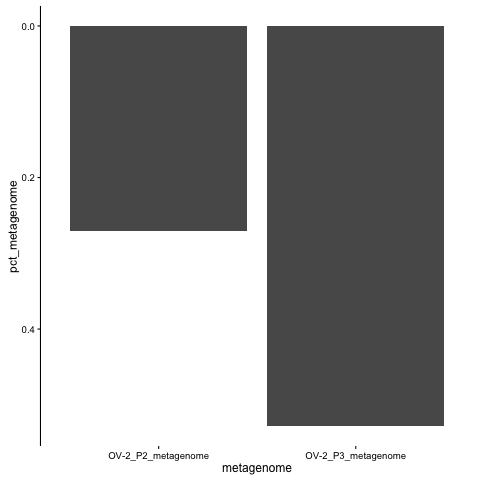

In [157]:
%%R
u <- underplot %>% ggplot(aes(metagenome, pct_metagenome)) + geom_bar(stat="identity") + theme_classic() + scale_y_reverse()
plot(u + theme(axis.line.y = element_line(color="black")))

In [158]:
%%R
total_mg_reads <- pairs[,8] %>% unique %>% sum

sideplot <- pairs %>% group_by(sag) %>% summarise(pct_reads_recruited_allmgs = (sum(total_reads_recruited)/total_mg_reads)*100)

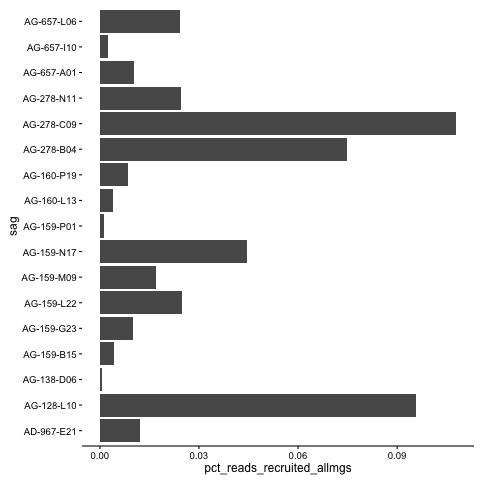

In [159]:
%%R
s <- sideplot %>% ggplot(aes(sag, pct_reads_recruited_allmgs)) + geom_bar(stat="identity") +  theme_classic()+ coord_flip()
plot(s + theme(axis.line.x = element_line(color="black")))

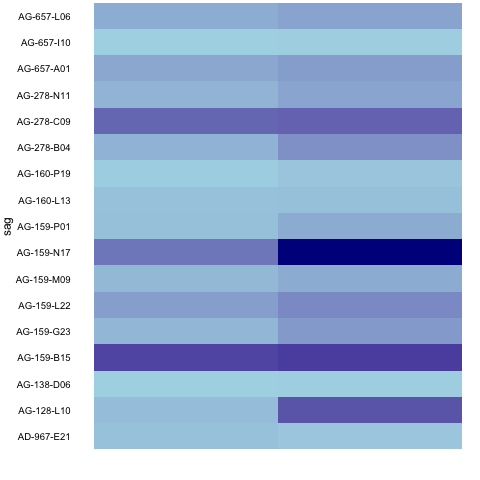

In [160]:
%%R
p1 <- pairs %>% ggplot(aes(metagenome, sag)) + geom_tile(aes(fill=prop_mgreads_per_mbp)) + theme_bw() + scale_fill_gradient(low="lightblue", high="darkblue")
pmain <- p1 + theme(axis.ticks = element_blank(), axis.title.x=element_blank(), axis.text.x=element_blank())
pmain <- pmain + theme(plot.margin=unit(c(0,0,25,0), "pt"))+labs(x=" ", fill="")
pmain <- pmain  + theme(legend.key.height=unit(50, "pt"), legend.position="none") 
pmain <- pmain + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), panel.background = element_blank()) 


plot(pmain)

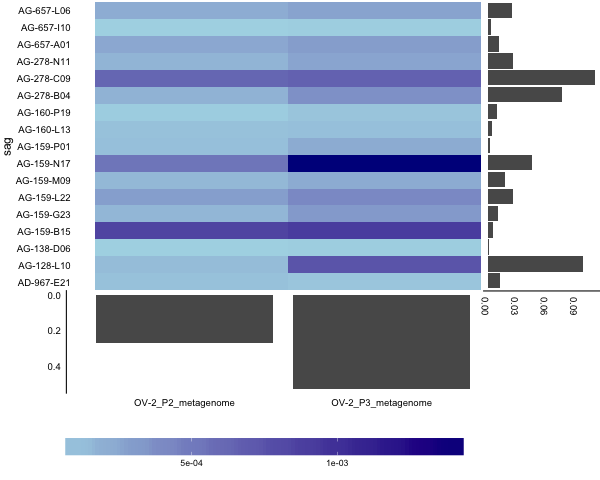

In [165]:
%%R -w 600

pside <- s + theme(axis.ticks = element_blank(), axis.text.y = element_blank(), axis.title = element_blank())
pside <- pside + theme(plot.margin=unit(c(0,0,5,-20),"pt"), 
                       axis.text.x = element_text(angle = -90))
pside <- pside + theme(panel.border = element_blank(), 
                       panel.grid.major = element_blank(),
                       panel.grid.minor = element_blank(), 
                       panel.background = element_blank(),
                       axis.line.x = element_line(color="black")) 

punder <- u + labs(y="", x="") + theme(plot.margin=unit(c(-30,0,5,32), "pt"))
punder <- punder + theme(panel.border = element_blank(), 
                         panel.grid.major = element_blank(),
                         panel.grid.minor = element_blank(), 
                         panel.background = element_blank(), 
                         axis.ticks = element_blank(),
                         axis.line.y = element_line(color="black")) 

pempty <-ggplot(df, aes(sag, metagenome)) + geom_blank() + theme(axis.text = element_blank(),
                axis.title = element_blank(),
                line = element_blank(),
                panel.background = element_blank(),
                plot.margin=unit(c(20,0,0,0), "pt"))

legend <- pairs %>% ggplot(aes(metagenome, sag)) + geom_blank(aes(fill=prop_mgreads_per_mbp))
legend <- legend + theme(axis.text = element_blank(),
                axis.title = element_blank(),
                line = element_blank(),
                panel.background = element_blank()) + labs(fill="")
legend <- legend + theme(legend.key.width=unit(80, "pt"), 
                         legend.position=c(.5, .5), 
                 legend.direction="horizontal") + scale_fill_gradient(low="lightblue", high="darkblue")
legend <- legend + theme(plot.margin=unit(c(0,10,0,32), "pt"))

final <- grid.arrange(pmain, pside, punder, pempty,legend, pempty,
             ncol = 2, nrow = 3, widths = c(5, 1), heights = c(6, 2, 1))

In [142]:
%%R
?png
png(filename = "../data/summary_tbls/eric_SPAM_vs_OV-2mgs_160721.png",
   width=600, height=600, units="px")
plot(final)
dev.off()

quartz_off_screen 
                3 


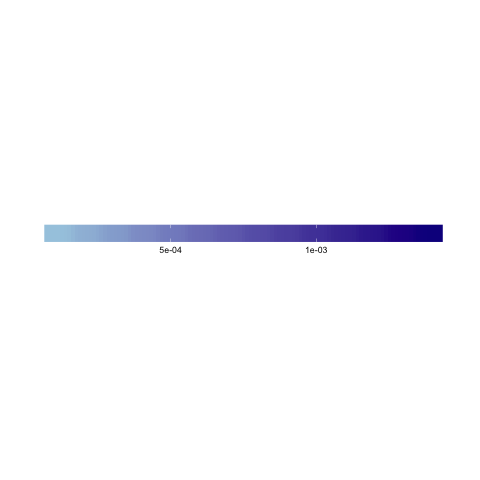

In [125]:
%%R 
legend <- pairs %>% ggplot(aes(metagenome, sag)) + geom_blank(aes(fill=prop_mgreads_per_mbp))
legend <- legend + theme(axis.text = element_blank(),
                axis.title = element_blank(),
                line = element_blank(),
                panel.background = element_blank()) +labs(fill="")
legend <- legend + theme(legend.key.width=unit(80, "pt"), 
                 legend.position=c(.5, .5), 
                 legend.direction="horizontal") + scale_fill_gradient(low="lightblue", high="darkblue")
plot(legend)

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
df = pd.read_csv("../data/summary_tbls/160708_eric_smr_summary_table.txt", sep="\t")

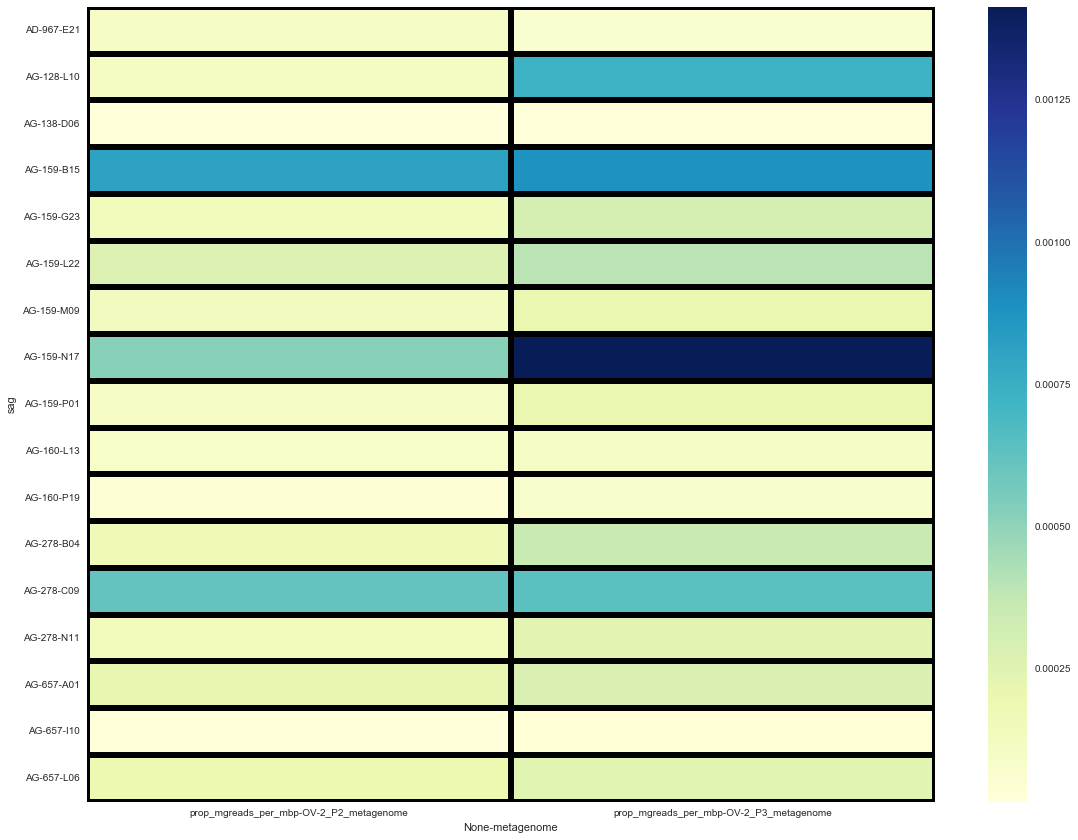

In [3]:
pmr = df[['sag','metagenome','prop_mgreads_per_mbp']].pivot(index='sag', columns='metagenome')

fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
#ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
#ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

hm = sns.heatmap(pmr, ax=ax1, annot=False, cmap="YlGnBu", linecolor='black', 
            linewidth=5, cbar = True)

In [4]:
g = df.groupby(['sag'])
newser = g['total_reads_recruited'].sum()/g['mg_read_count'].sum()
newser
#>>> data.groupby(func, axis=0).mean()
#>>> data.groupby(['col1', 'col2'])['col3'].mean()
print(newser.index)
print(newser.values)

Index([u'AD-967-E21', u'AG-128-L10', u'AG-138-D06', u'AG-159-B15',
       u'AG-159-G23', u'AG-159-L22', u'AG-159-M09', u'AG-159-N17',
       u'AG-159-P01', u'AG-160-L13', u'AG-160-P19', u'AG-278-B04',
       u'AG-278-C09', u'AG-278-N11', u'AG-657-A01', u'AG-657-I10',
       u'AG-657-L06'],
      dtype='object', name=u'sag')
[  1.17354255e-04   9.48772016e-04   6.99605003e-06   4.14022653e-05
   9.88416299e-05   2.42206840e-04   1.66470114e-04   4.37809223e-04
   1.21264867e-05   3.93931432e-05   8.39167232e-05   7.41007268e-04
   1.06124697e-03   2.38942016e-04   1.02501102e-04   2.40735875e-05
   2.34026843e-04]


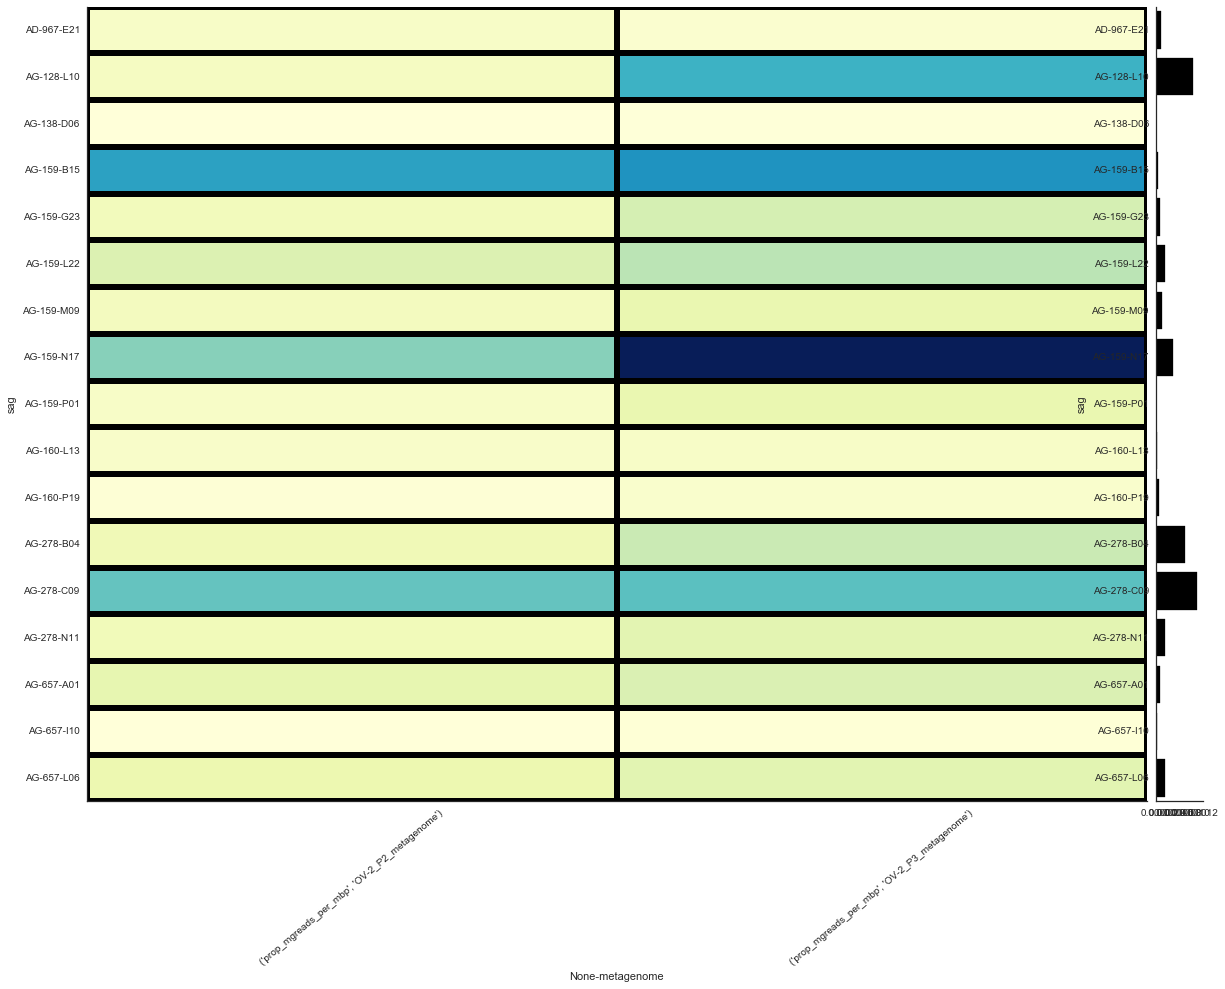

In [11]:

fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
#ax3 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
ax2 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

#mask = np.zeros_like(pv)
#mask[np.tril_indices_from(mask)] = True

#sns.heatmap(pv, ax=ax1, annot=True, cmap="YlGnBu",mask=mask, linecolor='b', cbar = False)
sns.heatmap(pmr, ax=ax1, annot=False, cmap="YlGnBu", linecolor='black', 
            linewidth=5, cbar = False)

ax1.set_xticklabels(pmr.columns,rotation=40)
sns.set_style("white")
sns.despine()

sns.barplot(y=newser.index, x=newser.values, color="black", ax=ax2)


#sns.heatmap((pd.DataFrame(pv.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)
#sns.heatmap(pd.DataFrame(pv.sum(axis=1)), ax=ax3,  annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=False)


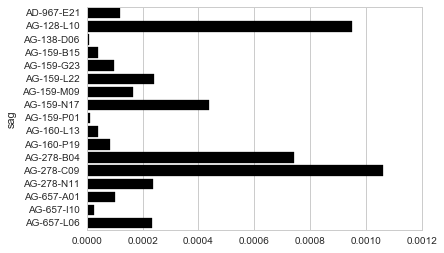

In [21]:
sns.set_style("whitegrid")
sp = sns.barplot(y=newser.index, x=newser.values, color="black")